# Make intended "Figure 1" for spectral ice paper

### Jonah Shaw, 09/20/2021

Four panels (potentially more) with contour plots of observed monthly trends  
1. dT/dt (GISStemp or HadCrut?)  
2. Ice extent trend (need to find gridded monthly product)
3. CERES ASR (03/2000 - 02/2020 or 01/2001 - 01/2020)
4. CERES OLR (03/2000 - 02/2020 or 01/2001 - 01/2020)

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set the time period.

In [62]:
tsel = slice('2001-01-01','2021-12-31')

## Load datasets

CERES, GISStemp, HadSST, NSIDC

### Load GISStemp data

The updated GISS record runs from 1880 until 2022-02, whereas CERES runs 2000-03 to 2021-02.

https://psl.noaa.gov/data/gridded/data.gistemp.html

In [5]:
# gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'
gisstemp_path = '/glade/work/jonahshaw/obs/GISTEMP/'

In [6]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [122]:
# giss_tsel = giss1.sel(time=tsel)['air']
giss_tsel = giss1.sel(time=tsel)['air']

In [124]:
giss1.close()

### Load HadSST3.1 data

Haven't used this before, but trying to find something with temperature records from the Arctic.

In [6]:
hadsst_path = '/glade/work/jonahshaw/obs/HadSST3.0/'
hadsst_file = 'HadSST.3.1.1.0.median.nc'

In [7]:
hadsst = xr.open_dataset('%s/%s' % (hadsst_path,hadsst_file))['sst']

### Load Berkeley BEST data

Berkeley Earth Surface Temperatures (BEST).

Haven't used this before. Was suggested by Jen/Dave.

http://berkeleyearth.org/data/

In [8]:
best_path = '/glade/work/jonahshaw/obs/BEST/'
best_file = 'Land_and_Ocean_LatLong1.nc'

In [83]:
best_temp = xr.open_dataset('%s/%s' % (best_path,best_file)).rename({'latitude':'lat','longitude':'lon'})

The time format is annoying. I will need to fix this.

In [84]:
# One-line command just creates values at the end of each month (functional by potentially confusing)
# times = pd.date_range("1850/01/01","2021/12/31",freq='1M',closed=None)

# Manual code w/ for loops :(
years = np.arange(1850,2021.1,1)
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

# manually create the time strings
time_str_list = []

for _yr in years: # Create list of time-string objects
    for _mnth in months:
        _new_str = '%s-%s-15' % (int(_yr),_mnth)
        time_str_list.append(_new_str)
        
times = pd.to_datetime(time_str_list) # turn into a pandas object
time_da = xr.DataArray(times, [('time', times)]) # turn into an xarray object

In [85]:
# Assign the new time coordinate
best_temp_timefixed = best_temp.assign_coords({'time':time_da})

In [86]:
best_temp_tsel = best_temp_timefixed['temperature'].sel(time=tsel)

### Load NSIDC data

~~Using the G10010 V2 product for now.~~ Now using G02202 regridded to quarter degree resolution.

The ancilliary data has the lat/lon point for each gridcell

In [6]:
g10010_path = '/glade/work/jonahshaw/obs/NSIDC/G10010_V2/'
g10010_file = 'G10010_sibt1850_v2.0.nc'

In [7]:
nsidc_seaice = xr.open_dataset('%s/%s' % (g10010_path,g10010_file))

Using the G02202 V4 product (recommended by Walt Meier) regridded to a 0.25x0.25 degree grid

In [65]:
g02202_path = '/glade/work/jonahshaw/obs/NSIDC/G02202_V4/latlon_gridding/'

In [66]:
g02202_files = glob.glob('%s/*monthly*.nc' % (g02202_path))
g02202_files.sort()

g02202_ancillary_file = glob.glob('%s/*ancillary*.nc' % (g02202_path))[0]

In [67]:
g02202_ds = xr.open_mfdataset(g02202_files,parallel=True) # this is slow, sometimes
g02202_ancillary_ds = xr.open_dataset(g02202_ancillary_file)

## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

__Reminder to update CERES obs through 2021 (only -2021/11 available as of 2022/03/22)__

In [71]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [72]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data
if os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
    ceres_asr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)
    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)) or (not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
    
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
        ceres_asr = all_ceres['solar_mon'] - all_ceres['toa_sw_all_mon']
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = all_ceres['toa_lw_all_mon']

## Load AIRS data

Combine ascending and descending total water vapor retrievals (equal averaging)
Remember that an AIRS/PREFIRE satellite simulator will need to subsample time of orbit to capture correct patterns.


I also have to get the units here. Jen suggested mm, which is maybe reasonable?

Seems legit after looking after this:
https://earthobservatory.nasa.gov/global-maps/MYDAL2_M_SKY_WV

The CESM2 variable TMQ is in units of kg/m^2.

If rho is 1000 kg / m^3, 1mm x 1m x 1m is 0.001 m^3 so the units are interchangeable.

In [13]:
airs_tseries_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'

In [14]:
tmq_a_file = 'AIRS.TotH2OVap_A.200209-202012.L3.RetStd.v7.nc'
tmq_d_file = 'AIRS.TotH2OVap_D.200209-202012.L3.RetStd.v7.nc'

In [15]:
tmq_a = xr.open_dataset('%s/%s' % (airs_tseries_dir,tmq_a_file))
tmq_d = xr.open_dataset('%s/%s' % (airs_tseries_dir,tmq_d_file))

tmq_a = tmq_a.rename({'TotH2OVap_A':'TotH2OVap'})
tmq_d = tmq_d.rename({'TotH2OVap_D':'TotH2OVap'})

In [16]:
_tmq_a = tmq_a['TotH2OVap'].assign_coords({'orbit':0}).expand_dims('orbit')
_tmq_d = tmq_d['TotH2OVap'].assign_coords({'orbit':1}).expand_dims('orbit')

In [17]:
tmq_both = xr.merge([_tmq_a,_tmq_d])
tmq_net = tmq_both.mean(dim='orbit')['TotH2OVap']

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [73]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [74]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [75]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Calculate trends and statistical significance

#### CERES ASR

In [76]:
# Subset data so computations are lighter and significance tests make sense
ceres_asr_subset = ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [77]:
asr_trends,asr_statsig,asr_notnull = compute_trends_n_signif2(ceres_asr_subset)

#### CERES OLR

In [78]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [79]:
olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif2(ceres_olr_subset)

#### Temperature from GISStemp

In [125]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=tsel,lat=slice(None,58)).mean('lon')

In [126]:
gisstemp_trends,gisstemp_statsig,gisstemp_notnull = compute_trends_n_signif2(gisstemp_subset)

#### Temperature from BEST

In [116]:
# Subset data so computations are lighter and significance tests make sense
besttemp_subset = best_temp_tsel.sel(time=tsel,lat=slice(58,None)).mean('lon')

In [117]:
besttemp_trends,besttemp_statsig,besttemp_notnull = compute_trends_n_signif2(besttemp_subset)

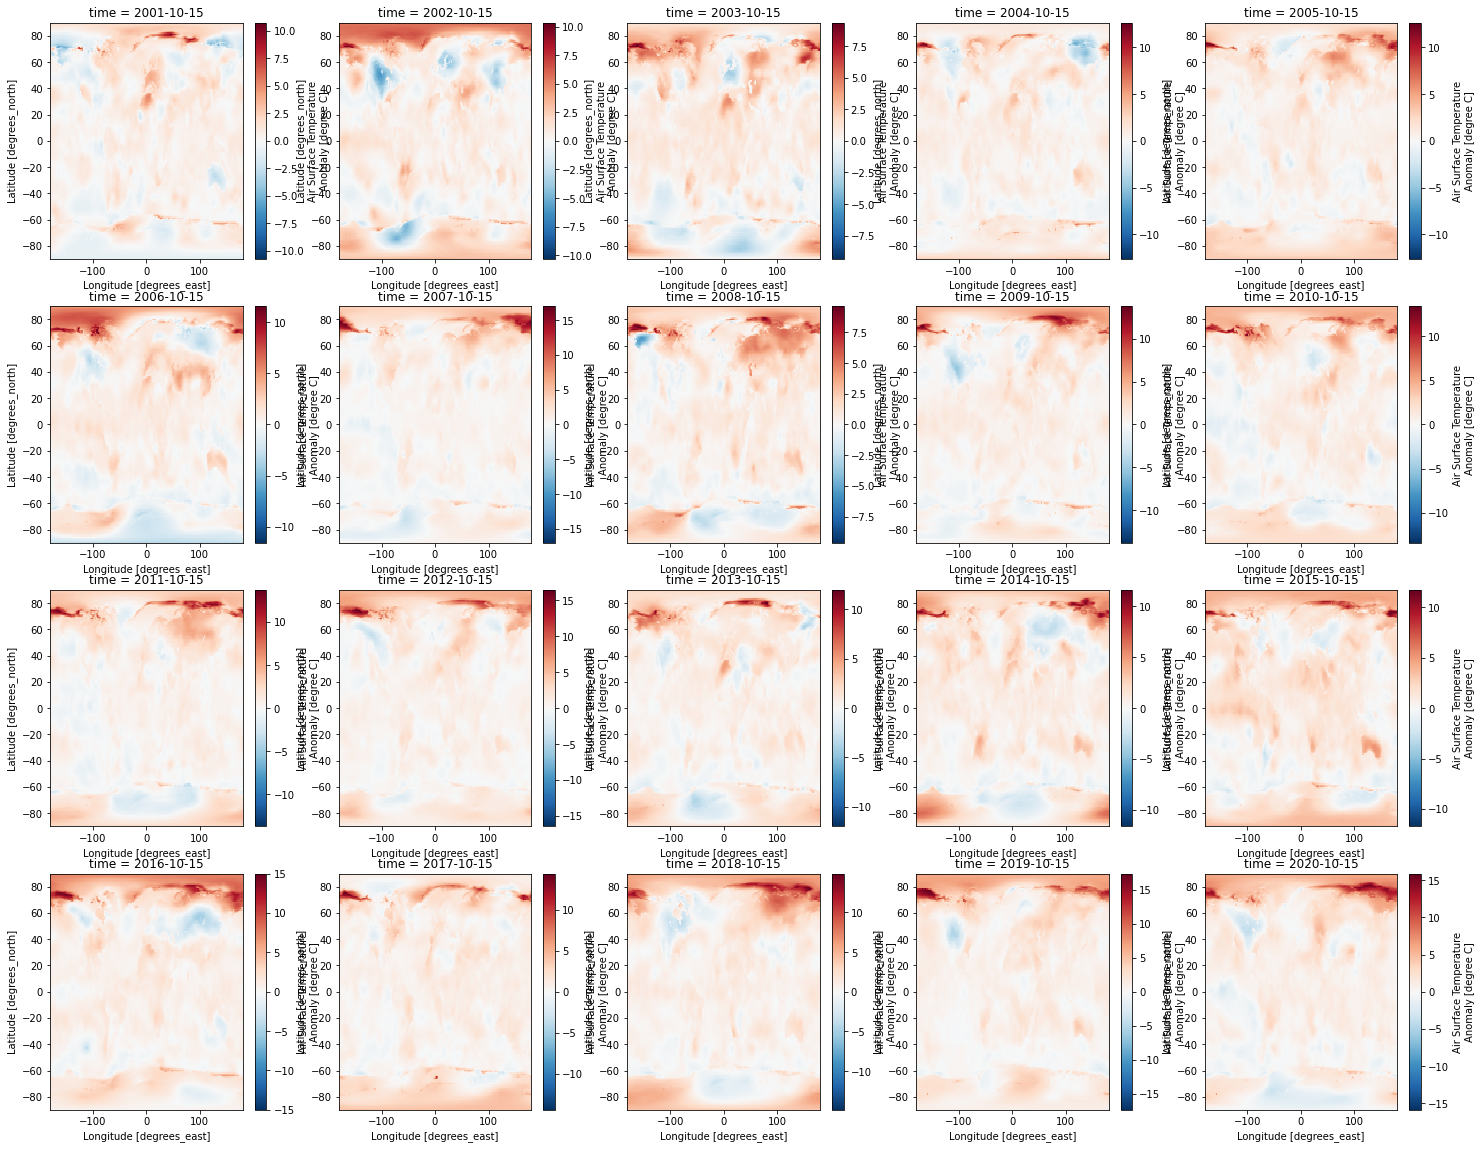

In [114]:
besttemp_oct = best_temp_tsel.sel(time=best_temp_tsel['time.month']==10)

test_fig,test_axs = plt.subplots(4,5,figsize=(25,20))

test_axs = test_axs.flat

for _ax,_tstep in zip(test_axs,besttemp_oct):
    
    _tstep.plot(ax=_ax)

#### Total WV column from AIRS

In [27]:
# Threw an error when the end date was 12-31
airs_tmq_subset = tmq_net.sel(time=slice('2003-01-01','2020-12-30'),lat=slice(None,58)).mean('lon')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [28]:
# time mean for plotting WV change in terms of percent (but why of entire time period mean 2000-2017?)
airs_tmq_subset_tmean = airs_tmq_subset.groupby('time.month').mean('time')

In [29]:
# duplicate the month/lat tmean values along the time dimension so that the observations can be normalized appropriately
dup_years = []
# create 17 duplicate years
for i in range(1,18):
    start_month = 12*i+1
    _months = np.arange(start_month,start_month+11.1,1)
    
    dup_year = airs_tmq_subset_tmean.assign_coords({'month':_months})
    dup_years.append(dup_year)
    
airs_tmq_subset_tmean_exp = xr.concat([airs_tmq_subset_tmean,*dup_years],dim='month') # I don't think this is strictly necessary

airs_tmq_subset_tmean_exp = airs_tmq_subset_tmean_exp.rename({'month':'time'})
airs_tmq_subset_tmean_exp = airs_tmq_subset_tmean_exp.assign_coords({'time':airs_tmq_subset['time']})

In [30]:
wv_trends,wv_statsig,wv_notnull = compute_trends_n_signif2(airs_tmq_subset)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [31]:
wv_pct_trends,wv_pct_statsig,wv_pct_notnull = compute_trends_n_signif2(airs_tmq_subset / airs_tmq_subset_tmean_exp)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [38]:
wv_pct_trends_old = 100*wv_trends / airs_tmq_subset_tmean

Text(0.5, 1.0, 'Mean WV column (2003-2021)')

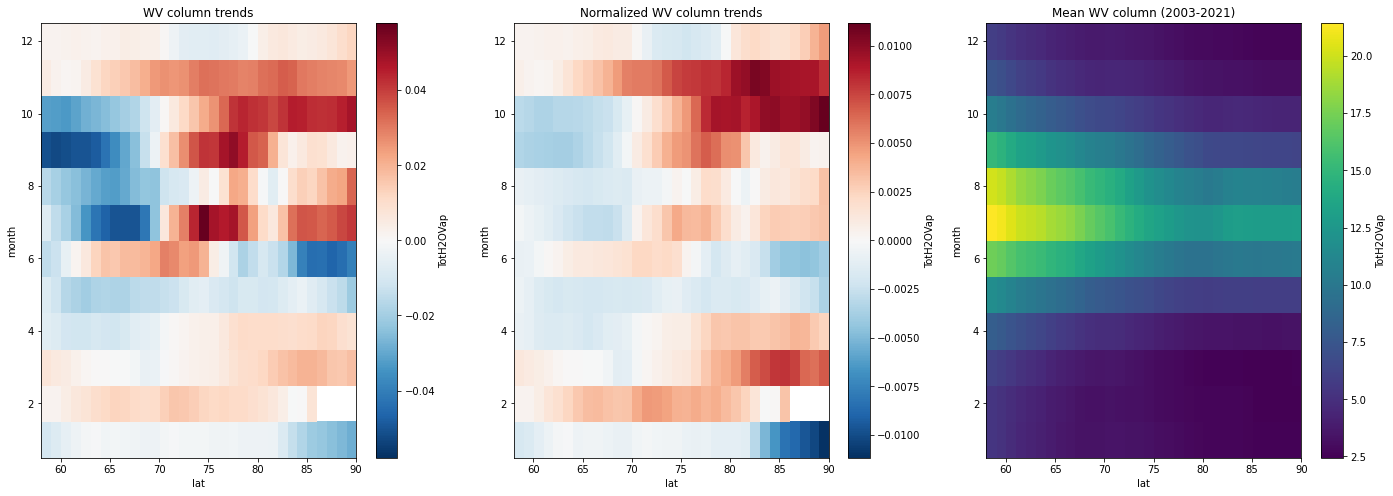

In [32]:
tmq_pct_fig,tmq_axs = plt.subplots(1,3,figsize=(24,8))
tmq_axs = tmq_axs.flat

# Plot absolute column WV trends
wv_trends.plot(ax=tmq_axs[0])
tmq_axs[0].set_title('WV column trends')

# Normalized WV trends
wv_pct_trends.plot(ax=tmq_axs[1])
tmq_axs[1].set_title('Normalized WV column trends')

# Plot average column WV
airs_tmq_subset_tmean.plot(ax=tmq_axs[2])
tmq_axs[2].set_title('Mean WV column (2003-2021)')

Normalizing highlights the fall trends (above).

#### Ice Concentration from NSIDC G10010

In [34]:
try:
    nsidc_seaice = nsidc_seaice.rename({'latitude':'lat','longitude':'lon'})
except:
    pass

# Subset by time and latitude
g10010_tsel = nsidc_seaice.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(90,59))

# Need to perform a masked and weighted average because areas are not constant and land cells must be masked
g10010_subset = masked_average(g10010_tsel['seaice_conc'],dim=['lon'],
                                      weights=g10010_tsel['Gridcell_Area'],mask=(g10010_tsel['LandRegion_mask']==20))

In [35]:
g10010_trends,g10010_statsig,g10010_notnull = compute_trends_n_signif2(g10010_subset)

#### Ice Concentration from NSIDC G02202

In [88]:
# Subset by time and latitude
g02202_ds = add_weights(g02202_ds)

# g02202_tsel = g02202_ds.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))
g02202_tsel = g02202_ds.sel(time=tsel,lat=slice(59,None))
g02202_temp = 100*g02202_tsel['cdr_seaice_conc_monthly'] #.chunk({'time':-1,'lat':-1,'lon':-1}) # I don't think this speeds things up

# Need to perform a weighted average because areas are not constant, land cells are already masked
g02202_subset = masked_average(g02202_temp,dim=['lon'], weights=g02202_tsel['cell_weight'],)
#                                mask=xr.ufuncs.isnan(g02202_ds['cdr_seaice_conc_monthly'][0])) # hide all gridcells with any interpolated land

In [89]:
g02202_trends,g02202_statsig,g02202_notnull = compute_trends_n_signif2(g02202_subset) # this should not take so long, but the resolution is much higher...

### Plot summary data

#### Wrap data for better visualization

In [127]:
gisstemp_trends_wrapped = xr.concat([gisstemp_trends,gisstemp_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_statsig_wrapped = xr.concat([gisstemp_statsig,gisstemp_statsig[0].assign_coords({'month':13})],dim='month')

besttemp_trends_wrapped = xr.concat([besttemp_trends,besttemp_trends[0].assign_coords({'month':13})],dim='month')
besttemp_statsig_wrapped = xr.concat([besttemp_statsig,besttemp_statsig[0].assign_coords({'month':13})],dim='month')

# g10010_trends_wrapped = xr.concat([g10010_trends,g10010_trends[0].assign_coords({'month':13})],dim='month')
# g10010_statsig_wrapped = xr.concat([g10010_statsig,g10010_statsig[0].assign_coords({'month':13})],dim='month')

g02202_trends_wrapped = xr.concat([g02202_trends,g02202_trends[0].assign_coords({'month':13})],dim='month')
g02202_statsig_wrapped = xr.concat([g02202_statsig,g02202_statsig[0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([asr_trends,asr_trends[0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([asr_statsig,asr_statsig[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([olr_statsig,olr_statsig[0].assign_coords({'month':13})],dim='month')

In [36]:
wv_trends_wrapped = xr.concat([wv_trends,wv_trends[0].assign_coords({'month':13})],dim='month')
wv_statsig_wrapped = xr.concat([wv_statsig,wv_statsig[0].assign_coords({'month':13})],dim='month')

wv_pct_trends_wrapped = xr.concat([wv_pct_trends,wv_pct_trends[0].assign_coords({'month':13})],dim='month')
wv_pct_statsig_wrapped = xr.concat([wv_pct_statsig,wv_pct_statsig[0].assign_coords({'month':13})],dim='month')

Text(0.5, 0.95, 'Observed Trends')

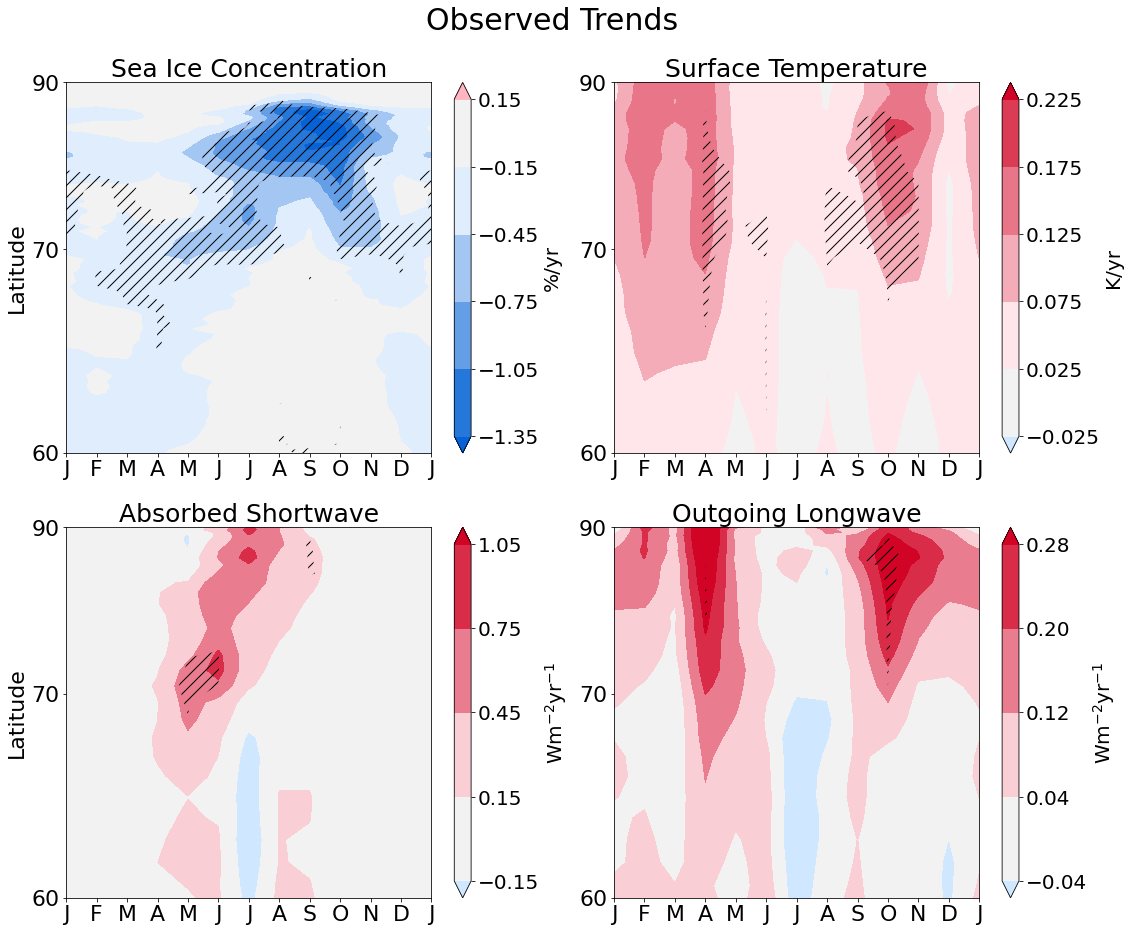

In [129]:
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=5, as_cmap=True)

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
fig1.subplots_adjust(wspace=0.2,hspace=0.2)

axes = axs.flat

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)

axes[0].set_ylabel('Latitude',fontsize=22)
axes[2].set_ylabel('Latitude',fontsize=22)
    
lat_weighted0 = np.sin(np.pi/180*g02202_trends_wrapped['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(g02202_trends_wrapped['month'],lat_weighted0,g02202_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-1.35,0.156,0.3),vmin=-1.35,vmax=1.35)
im0.cmap.set_over('lightpink')
stip = axes[0].contourf(g02202_statsig_wrapped['month'],lat_weighted0,g02202_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice Concentration',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='%/yr',fontsize=20)

# lat_weighted1 = np.sin(np.pi/180*gisstemp_trends['lat']) # Using GISTEMP
# cmap1 = copy.copy(palette)
# im1 = axes[1].contourf(gisstemp_trends_wrapped['month'],lat_weighted1,gisstemp_trends_wrapped.transpose('lat','month'),
#                        cmap=cmap1,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
# im1.cmap.set_under((0.81,0.91,1.00))
# stip = axes[1].contourf(gisstemp_statsig_wrapped['month'],lat_weighted1,gisstemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
lat_weighted1 = np.sin(np.pi/180*besttemp_trends['lat']) # Using BEST-temp
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(besttemp_trends_wrapped['month'],lat_weighted1,besttemp_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im1.cmap.set_under((0.81,0.91,1.00))
stip = axes[1].contourf(besttemp_statsig_wrapped['month'],lat_weighted1,besttemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('Surface Temperature',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='K/yr',fontsize=20)

lat_weighted2 = np.sin(np.pi/180*asr_trends['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap2,extend='both',levels=np.arange(-0.15,1.06,0.30),vmin=-1.05,vmax=1.05)
im2.cmap.set_under((0.81,0.91,1.00))
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('Absorbed Shortwave',fontsize=25)
cbar2 = plt.colorbar(im2,ax=axes[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

lat_weighted3 = np.sin(np.pi/180*olr_trends['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im3.cmap.set_under((0.81,0.91,1.00))
stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('Outgoing Longwave',fontsize=25)
cbar3 = plt.colorbar(im3,ax=axes[3])
cbar3.ax.tick_params(labelsize=20)
cbar3.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

fig1.suptitle('Observed Trends',fontsize=30,y=0.95)

In [25]:
to_png(fig1,'observedtrends_4panel_G02202')

### Add water vapor from AIRS in 5th (3rd) panel

Text(0.5, 0.95, 'Observed Trends')

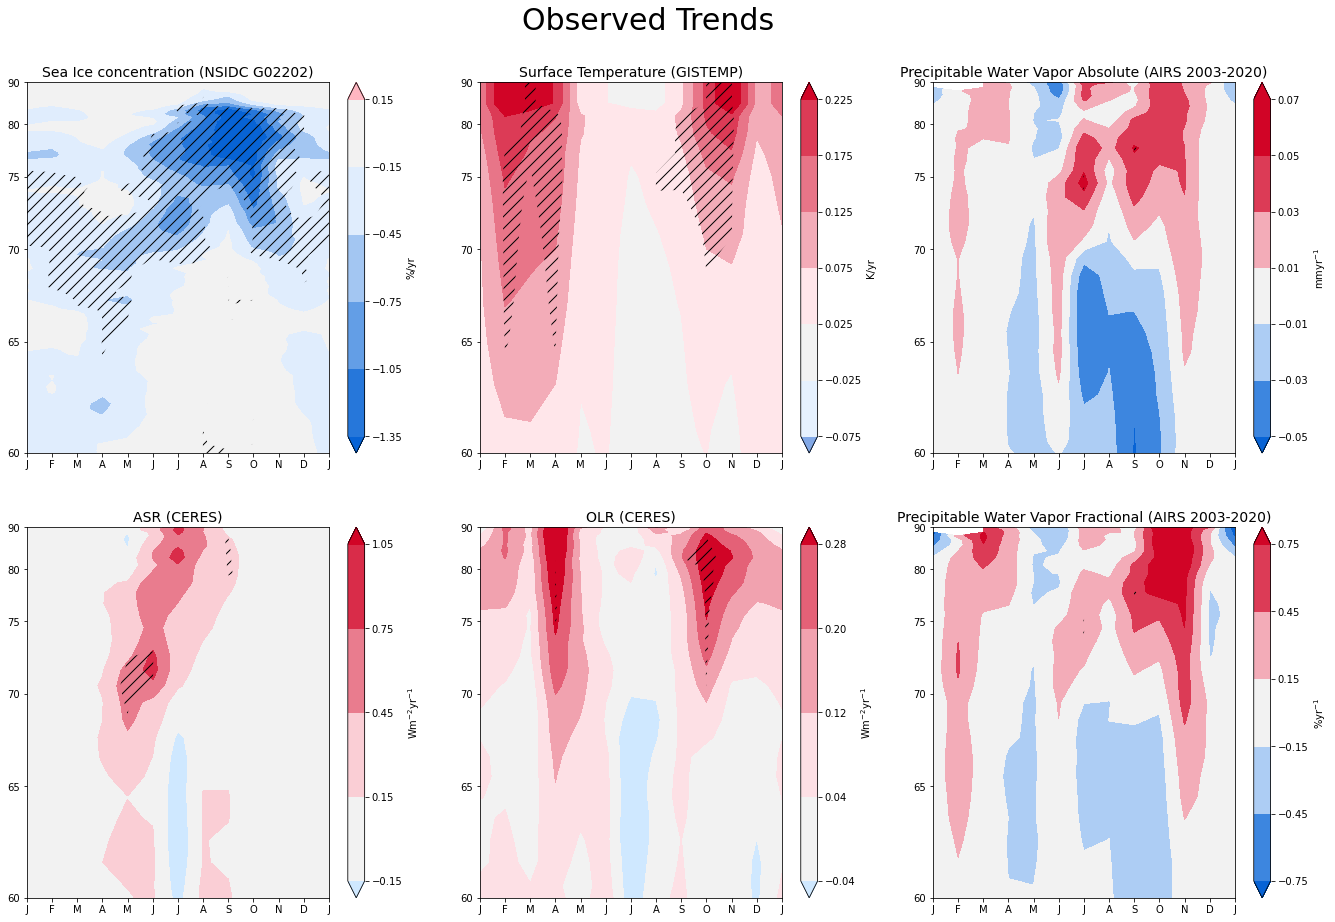

In [43]:
fig1,axs = plt.subplots(nrows=2,ncols=3,figsize=(23,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*g02202_trends_wrapped['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(g02202_trends_wrapped['month'],lat_weighted0,g02202_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=cmap0,levels=np.arange(-1.35,0.156,0.3),vmin=-1.35,vmax=1.35,extend='both')
#                        ,levels=np.arange(-0.9,0.11,0.2),extend='both')
im0.cmap.set_over('lightpink') # (0.51,0.66,0.9)
stip = axes[0].contourf(g02202_statsig_wrapped['month'],lat_weighted0,g02202_statsig_wrapped.transpose('lat','month'),
                        colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration (NSIDC G02202)',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*gisstemp_trends_wrapped['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_trends_wrapped['month'],lat_weighted1,gisstemp_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=cmap1,vmin=-0.25, vmax=0.25,levels=np.arange(-0.075,0.2251,0.05),extend='both')
im1.cmap.set_under((0.51,0.66,0.9))
stip = axes[1].contourf(gisstemp_statsig_wrapped['month'],lat_weighted1,gisstemp_statsig_wrapped.transpose('lat','month'),
                        colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')
axes[1].set_title('Surface Temperature (GISTEMP)',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

### Absolute change in WV
lat_weighted2 = np.sin(np.pi/180*wv_trends_wrapped['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(wv_trends_wrapped['month'],lat_weighted2,wv_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=cmap2,vmin=-0.05, vmax=0.05,extend='both',levels=np.arange(-0.05,0.071,0.02))
# im2.cmap.set_under('blue') # (0.81,0.91,1.00)
stip = axes[2].contourf(wv_statsig_wrapped['month'],lat_weighted2,wv_statsig_wrapped.transpose('lat','month'),
                        colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')
axes[2].set_title('Precipitable Water Vapor Absolute (AIRS 2003-2020)',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='mmyr$^{-1}$')

### Fractional change in WV, # wv_pct_trends_wrapped wv_pct_statsig_wrapped
lat_weighted5 = np.sin(np.pi/180*wv_pct_trends_wrapped['lat'])
cmap5 = copy.copy(palette)
im5 = axes[5].contourf(wv_pct_trends_wrapped['month'],lat_weighted5,100*wv_pct_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=cmap5,extend='both',vmin=-0.75, vmax=0.75,levels=np.arange(-0.75,0.751,0.3))
# im2.cmap.set_under('blue') # (0.81,0.91,1.00)
stip = axes[5].contourf(wv_pct_statsig_wrapped['month'],lat_weighted5,wv_pct_statsig_wrapped.transpose('lat','month'),
                        colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')
axes[5].set_title('Precipitable Water Vapor Fractional (AIRS 2003-2020)',fontsize=14)
plt.colorbar(im5,ax=axes[5],label='%yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(asr_trends_wrapped['month'],lat_weighted3,asr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap3,vmin=-1.05, vmax=1.05,levels=np.arange(-0.15,1.06,0.30),extend='both')
im3.cmap.set_under((0.81,0.91,1.00))
stip = axes[3].contourf(asr_statsig_wrapped['month'],lat_weighted3,asr_statsig_wrapped.transpose('lat','month'),
                        colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')
axes[3].set_title('ASR (CERES)',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted4 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
cmap4 = copy.copy(palette)
im4 = axes[4].contourf(olr_trends_wrapped['month'],lat_weighted4,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap4,vmin=-0.36,vmax=0.36,levels=np.arange(-0.04,0.36,0.08),extend='both')
im4.cmap.set_under((0.81,0.91,1.00))
stip = axes[4].contourf(olr_statsig_wrapped['month'],lat_weighted4,olr_statsig_wrapped.transpose('lat','month'),
                        colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')
axes[4].set_title('OLR (CERES)',fontsize=14)
plt.colorbar(im4,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Observed Trends',fontsize=30,y=0.95)

#### Plot with same colorbars as ensemble range

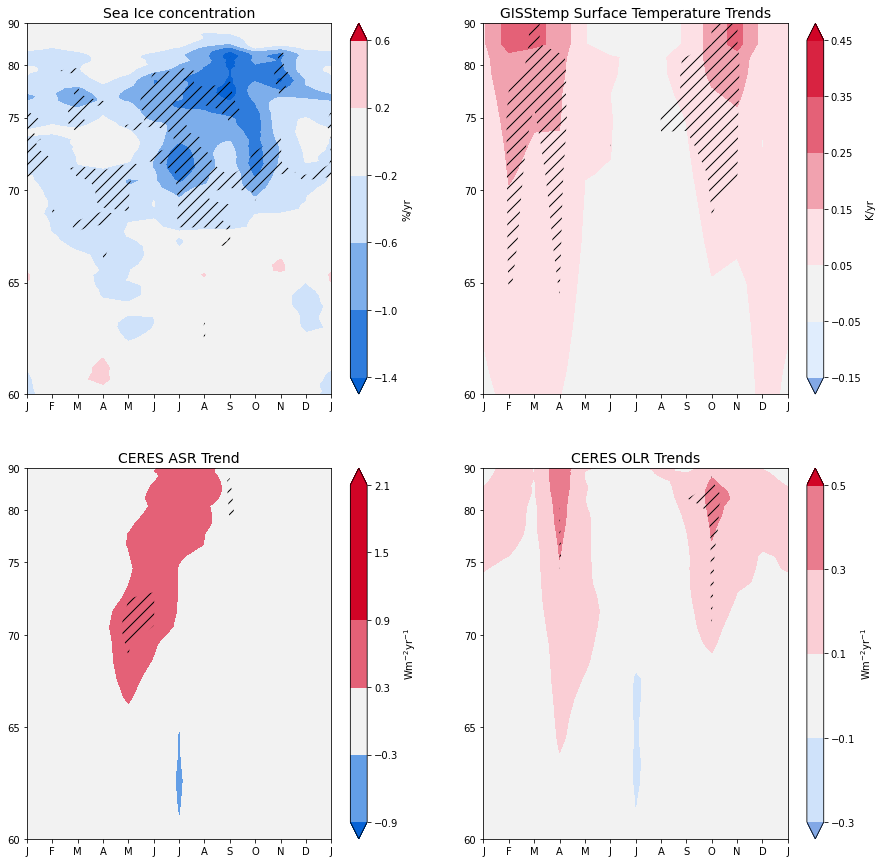

In [27]:
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*g10010_trends['lat'])
im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
                       cmap=palette,vmin=-1.4, vmax=1.4,levels=np.arange(-1.4,0.61,0.4),extend='both')
stip = axes[0].contourf(g10010_statsig_wrapped['month'],lat_weighted0,g10010_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')
    
lat_weighted1 = np.sin(np.pi/180*gisstemp_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_trends_wrapped['month'],lat_weighted1,gisstemp_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,vmin=-0.45, vmax=0.45,levels=np.arange(-0.15,0.451,0.1),extend='both')
im1.cmap.set_under((0.51,0.66,0.9))
stip = axes[1].contourf(gisstemp_statsig_wrapped['month'],lat_weighted1,gisstemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'),
                       cmap=palette,vmin=-0.9, vmax=0.90,levels=np.arange(-0.9,2.11,0.6),extend='both')
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,vmin=-0.7, vmax=0.7,levels=np.arange(-0.3,0.7,0.2),extend='both')
im3.cmap.set_under((0.51,0.66,0.9))
stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')


### Do line plots as suggested by Will B.

In [31]:
gisstemp_wgts = np.cos(gisstemp_trends_wrapped.lat*np.pi/180)
gisstemp_line = masked_average(gisstemp_trends_wrapped,dim='lat',weights=gisstemp_wgts)

In [36]:
g10010_wgts = np.cos(g10010_trends_wrapped.lat*np.pi/180)
g10010_line = masked_average(g10010_trends_wrapped,dim='lat',weights=g10010_wgts)

In [38]:
asr_wgts = np.cos(asr_trends_wrapped.lat*np.pi/180)
asr_line = masked_average(asr_trends_wrapped,dim='lat',weights=asr_wgts)

In [42]:
olr_wgts = np.cos(olr_trends_wrapped.lat*np.pi/180)
olr_line = masked_average(olr_trends_wrapped,dim='lat',weights=olr_wgts)

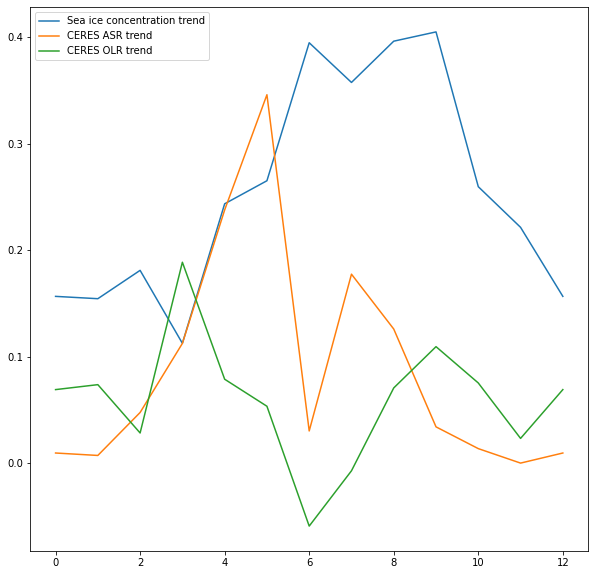

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(-1*g10010_line,label='Sea ice concentration trend')
ax.plot(asr_line,label='CERES ASR trend')
ax.plot(olr_line,label='CERES OLR trend')
ax.plot(gisstemp_line,label='GISTEMP Temperature trend')

plt.legend()

### Create plots with ocean/continent masks

This will be unchanged for the sea ice, so I just need to interpolate the ocean mask into the CERES and GISStemp grids and then apply them separately.

In [123]:
landmask = xr.where(g10010_tsel['LandRegion_mask']==20,1,0)

In [124]:
ceres_landmask = landmask.interp_like(ceres_asr['ASR'][0])

In [125]:
gisstemp_landmask = landmask.interp_like(giss_tsel[0])

The mask is smeared when interpolated to the lower resolution, so I will need a cutoff value.

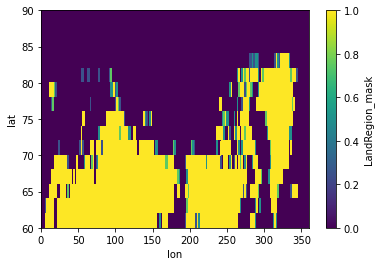

In [41]:
gisstemp_landmask.sel(lat=slice(90,60)).plot()

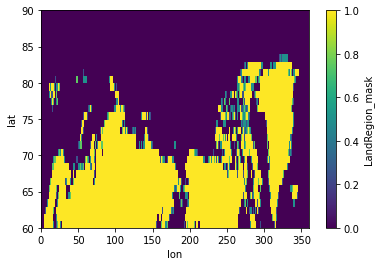

In [42]:
ceres_landmask.sel(lat=slice(60,90)).plot()

### Recompute trends with masked arrays

Sea will be mask < 0.1. Land will be mask > 0.9.

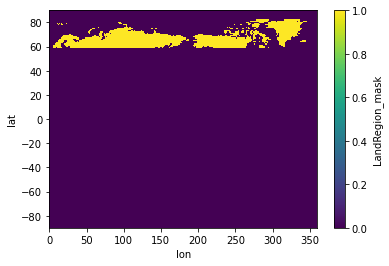

In [43]:
(ceres_landmask>0.9).plot()

#### CERES ASR

In [126]:
# Mask convention is to hide the pass gridcells
# Only take cells with <10% land coverage
ceres_asr_seasubset = masked_average(ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)),dim=['lon'],mask=ceres_landmask>0.1)
# Only take cells with >90% land coverage
ceres_asr_landsubset = masked_average(ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)),dim=['lon'],mask=ceres_landmask<0.9)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### CERES OLR

In [127]:
# Mask convention is to hide the pass gridcells
# Only take cells with <10% land coverage
ceres_olr_seasubset = masked_average(ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)),dim=['lon'],mask=ceres_landmask>0.1)
# Only take cells with >90% land coverage
ceres_olr_landsubset = masked_average(ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)),dim=['lon'],mask=ceres_landmask<0.9)

#### GISStemp

In [128]:
gisstemp_seasubset = masked_average(giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)),dim=['lon'],mask=gisstemp_landmask>0.1)

gisstemp_landsubset = masked_average(giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)),dim=['lon'],mask=gisstemp_landmask<0.9)

The sea ice data is already masked so I don't need to change anything, though I could think about adding something else for the continental data...what though?

### Compute trends on masked data

#### CERES ASR observations

In [129]:
asr_seasubset_trends,asr_seasubset_statsig,asr_seasubset_notnull = compute_trends_n_signif(ceres_asr_seasubset)

In [130]:
asr_landsubset_trends,asr_landsubset_statsig,asr_landsubset_notnull = compute_trends_n_signif(ceres_asr_landsubset)

#### CERES OLR observations

In [131]:
olr_seasubset_trends,olr_seasubset_statsig,olr_seasubset_notnull = compute_trends_n_signif(ceres_olr_seasubset)

In [132]:
olr_landsubset_trends,olr_landsubset_statsig,olr_landsubset_notnull = compute_trends_n_signif(ceres_olr_landsubset)

#### GISStemp observations

In [133]:
gisstemp_seasubset_trends,gisstemp_seasubset_statsig,gisstemp_seasubset_notnull = compute_trends_n_signif(gisstemp_seasubset)
gisstemp_landsubset_trends,gisstemp_landsubset_statsig,gisstemp_landsubset_notnull = compute_trends_n_signif(gisstemp_landsubset)

### Plot masked sea-only and land-only data

#### Seasubset data

In [134]:
gisstemp_seasubset_trends_wrapped = xr.concat([gisstemp_seasubset_trends,gisstemp_seasubset_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_seasubset_statsig_wrapped = xr.concat([gisstemp_seasubset_statsig,gisstemp_seasubset_statsig[0].assign_coords({'month':13})],dim='month')

asr_seasubset_trends_wrapped = xr.concat([asr_seasubset_trends,asr_seasubset_trends[0].assign_coords({'month':13})],dim='month')
asr_seasubset_statsig_wrapped = xr.concat([asr_seasubset_statsig,asr_seasubset_statsig[0].assign_coords({'month':13})],dim='month')

olr_seasubset_trends_wrapped = xr.concat([olr_seasubset_trends,olr_seasubset_trends[0].assign_coords({'month':13})],dim='month')
olr_seasubset_statsig_wrapped = xr.concat([olr_seasubset_statsig,olr_seasubset_statsig[0].assign_coords({'month':13})],dim='month')

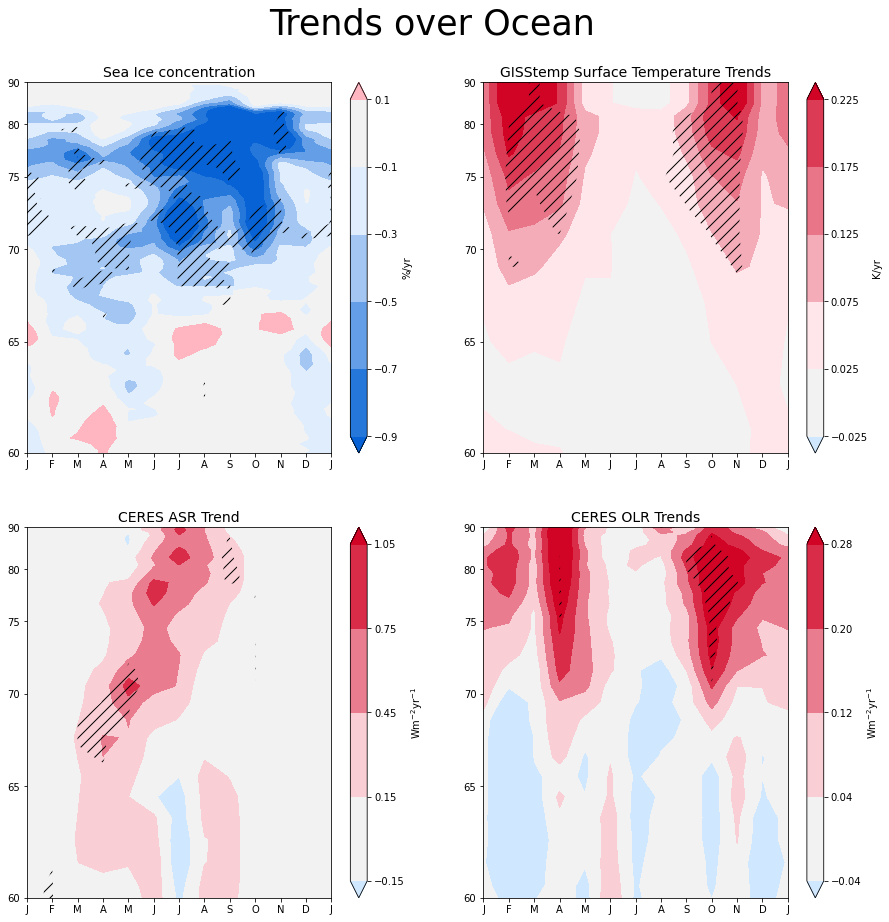

In [153]:
fig1b,axs1b = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
fig1b.suptitle('Trends over Ocean',fontsize=35,y=0.95)

axes = axs1b.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*g10010_trends['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.9,0.11,0.2),vmin=-0.9,vmax=0.9)
im0.cmap.set_over('lightpink')
# im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
stip = axes[0].contourf(g10010_statsig_wrapped['month'],lat_weighted0,g10010_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')
    
lat_weighted1 = np.sin(np.pi/180*gisstemp_seasubset_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_seasubset_trends_wrapped['month'],lat_weighted1,gisstemp_seasubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im1.cmap.set_under((0.81,0.91,1.00))
# im1 = axes[1].contourf(gisstemp_seasubset_trends_wrapped['month'],lat_weighted1,gisstemp_seasubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
stip = axes[1].contourf(gisstemp_seasubset_statsig_wrapped['month'],lat_weighted1,gisstemp_seasubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_seasubset_trends['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(asr_seasubset_trends_wrapped['month'],lat_weighted2,asr_seasubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap2,extend='both',levels=np.arange(-0.15,1.06,0.30),vmin=-1.05,vmax=1.05)
im2.cmap.set_under((0.81,0.91,1.00))
# im2 = axes[2].contourf(asr_seasubset_trends_wrapped['month'],lat_weighted2,asr_seasubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
stip = axes[2].contourf(asr_seasubset_statsig_wrapped['month'],lat_weighted2,asr_seasubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_seasubset_trends['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_seasubset_trends_wrapped['month'],lat_weighted3,olr_seasubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im3.cmap.set_under((0.81,0.91,1.00))
# im3 = axes[3].contourf(olr_seasubset_trends_wrapped['month'],lat_weighted3,olr_seasubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
stip = axes[3].contourf(olr_seasubset_statsig_wrapped['month'],lat_weighted3,olr_seasubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')


#### Land subset data

In [136]:
gisstemp_landsubset_trends_wrapped = xr.concat([gisstemp_landsubset_trends,gisstemp_landsubset_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_landsubset_statsig_wrapped = xr.concat([gisstemp_landsubset_statsig,gisstemp_landsubset_statsig[0].assign_coords({'month':13})],dim='month')

asr_landsubset_trends_wrapped = xr.concat([asr_landsubset_trends,asr_landsubset_trends[0].assign_coords({'month':13})],dim='month')
asr_landsubset_statsig_wrapped = xr.concat([asr_landsubset_statsig,asr_landsubset_statsig[0].assign_coords({'month':13})],dim='month')

olr_landsubset_trends_wrapped = xr.concat([olr_landsubset_trends,olr_landsubset_trends[0].assign_coords({'month':13})],dim='month')
olr_landsubset_statsig_wrapped = xr.concat([olr_landsubset_statsig,olr_landsubset_statsig[0].assign_coords({'month':13})],dim='month')

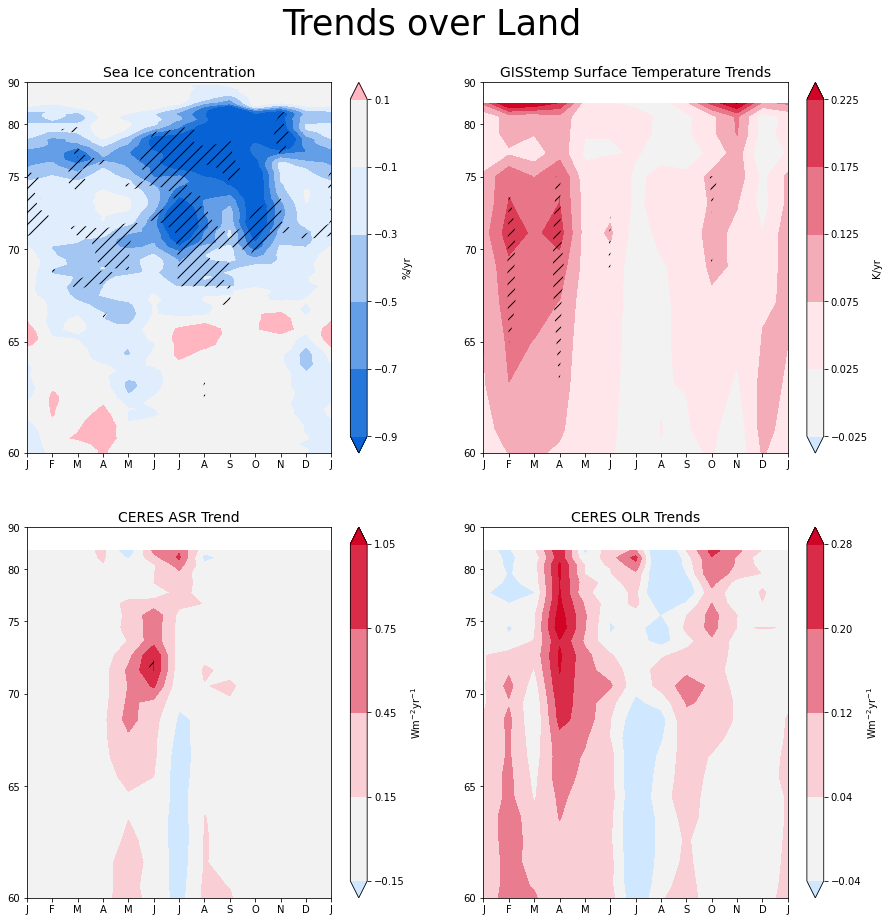

In [152]:
fig1c,axs1c = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
fig1c.suptitle('Trends over Land',fontsize=35,y=0.95)

axes = axs1c.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*g10010_trends['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.9,0.11,0.2),vmin=-0.9,vmax=0.9)
im0.cmap.set_over('lightpink')
# im0 = axes[0].contourf(g10010_trends_wrapped['month'],lat_weighted0,g10010_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
stip = axes[0].contourf(g10010_statsig_wrapped['month'],lat_weighted0,g10010_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')
    
lat_weighted1 = np.sin(np.pi/180*gisstemp_landsubset_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(gisstemp_landsubset_trends_wrapped['month'],lat_weighted1,gisstemp_landsubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im1.cmap.set_under((0.81,0.91,1.00))
# im1.cmap.set_under([0,0.67,1])
# im1 = axes[1].contourf(gisstemp_landsubset_trends_wrapped['month'],lat_weighted1,gisstemp_landsubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
stip = axes[1].contourf(gisstemp_landsubset_statsig_wrapped['month'],lat_weighted1,gisstemp_landsubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('GISStemp Surface Temperature Trends',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_landsubset_trends['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(asr_landsubset_trends_wrapped['month'],lat_weighted2,asr_landsubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap2,extend='both',levels=np.arange(-0.15,1.06,0.30),vmin=-1.05,vmax=1.05)
im2.cmap.set_under((0.81,0.91,1.00))
# im2 = axes[2].contourf(asr_landsubset_trends_wrapped['month'],lat_weighted2,asr_landsubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
stip = axes[2].contourf(asr_landsubset_statsig_wrapped['month'],lat_weighted2,asr_landsubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_landsubset_trends['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_landsubset_trends_wrapped['month'],lat_weighted3,olr_landsubset_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im3.cmap.set_under((0.81,0.91,1.00))
# im3 = axes[3].contourf(olr_landsubset_trends_wrapped['month'],lat_weighted3,olr_landsubset_trends_wrapped.transpose('lat','month'),
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
stip = axes[3].contourf(olr_landsubset_statsig_wrapped['month'],lat_weighted3,olr_landsubset_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')
